# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf

## What's the standard deviation?

Here's a question that appeared [on Reddit](https://www.reddit.com/r/statistics/comments/hcvl2j/q_reverse_empirical_distribution_rule_question/) recently:

> I am trying to approximate a distribution based on the 68-95-99.7 rule--but in reverse. I would like to find an approximation for standard deviation, given:
> 
> Assumed normal dist.
> 
> Mean = 22.6
> 
> n = 100
> 
> 19 of n scored less than 10.0
> 
> Min = 0, Max = 37
> 
> My intuition tells me that it is possible to solve this problem but I don't think I learned how to do it in school and don't know the right words to use to look it up. Thanks for any assistance!!!

A user named efrique responded:

> You have 19% less than 10

> If the sample size were large enough (100 isn't very large, so this will have a fair bit of noise in it), you could just look at the 19th percentile of a normal. That's `-0.8779` standard deviations below the mean, implying `22.6-10 = 12.6` is 0.8779 of a standard deviation.

First, let's check his math.  I'll compute the 19th percentile of the standard normal distribution:

In [3]:
from scipy.stats import norm
norm.ppf(0.19)

-0.8778962950512288

So we expect the 19th percentile to be 0.8779 standard deviations below the mean.  In the data, the 19th percentile is 12.6 points below the mean, which suggests that the standard deviation is

In [4]:
sigma = 12.6 / 0.8779
sigma

14.352431939856475

Let's see what Bayes has to say about it.

If we knew that the standard deviation was 14, for example, we could compute the probability of a score less than or equal to 10:



In [5]:
sigma = 14
dist = norm(22.6, sigma)
ple10 = dist.cdf(10)
ple10

0.18406012534675947

Then we could use the binomial distribution to compute the probability that 19 out of 100 are less than or equal to 10.

In [6]:
from scipy.stats import binom

binom(100, ple10).pmf(19)

0.10005564608778429

But we don't know the standard deviation.  So I'll make up a range of possible values.

In [7]:
hypos = np.linspace(1, 41, 101)

Now we can compute the probability of a score less than or equal to 10 under each hypothesis.

In [8]:
ple10s = norm(22.6, hypos).cdf(10)
ple10s.shape

(101,)

And the probability that 19 out of 100 would be less than or equal to 10.

In [9]:
likelihood1 = binom(100, ple10s).pmf(19)
likelihood1.shape

(101,)

Here's what it looks like.

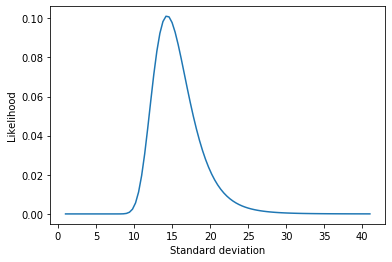

In [10]:
plt.plot(hypos, likelihood1)

plt.xlabel('Standard deviation')
plt.ylabel('Likelihood');

If we have no other information about sigma, we could use a uniform prior.

In [11]:
prior = Pmf(1, hypos)
posterior = prior * likelihood1
posterior.normalize()

1.6224932532278136

In that case the posterior looks just like the likelihood, except that the probabilities are normalized.

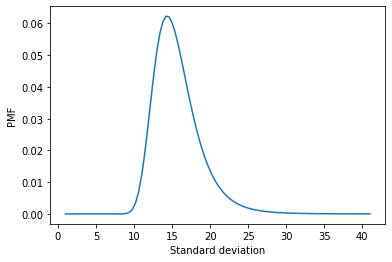

In [12]:
posterior.plot()
plt.xlabel('Standard deviation')
plt.ylabel('PMF');

The most likely value in the posterior distribution is 14.2, which is consistent with the estimate we computed above.

In [13]:
posterior.max_prob()

14.200000000000001

The posterior mean is a little higher.

In [14]:
posterior.mean()

15.686820411746856

And the credible interval is pretty wide.

In [15]:
posterior.credible_interval(0.9)

array([11.8, 21.4])

## Using the minimum

However, we have left some information on the table.  We also know that the low score was 37, which is the minimum score possible.

If we knew sigma, we could compute the probability of a score less than or equal to 0.

In [16]:
sigma = 14
dist = norm(22.6, sigma)
plt0 = dist.cdf(0)
plt0

0.053232733658762056

And the probability that at least one person gets a score less than or equal to 0.

I'm using `sf`, which computes the survival function, also known as the complementary CDF, or `1 - cdf(x)`.

In [17]:
binom(100, plt0).sf(0)

0.9957895994273191

With mean 22.6 and standard deviation 14, it is likely that someone would get a 0.

If the standard deviation were lower, it would be less likely, so this data provides some evidence, but not much.

Nevertheless can do the same computation for the range of possible sigmas.

In [18]:
plt0s = norm(22.6, hypos).cdf(0)

And compute the likelihood that at least one person gets a 37.

In [19]:
likelihood2 = binom(100, plt0s).sf(0)

Here's what it looks like.

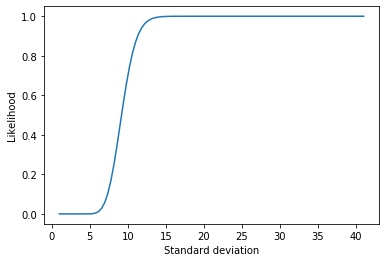

In [20]:
plt.plot(hypos, likelihood2)
plt.xlabel('Standard deviation')
plt.ylabel('Likelihood');

The fact that someone got a 0 rules out some low standard deviations, but they were already nearly ruled out, so this information doesn't have much effect on the posterior.

In [21]:
prior = Pmf(1, hypos)
prior.normalize()
posterior2 = prior * likelihood1 * likelihood2
posterior2.normalize()

0.015862650446584026

Here's what the posteriors look like:

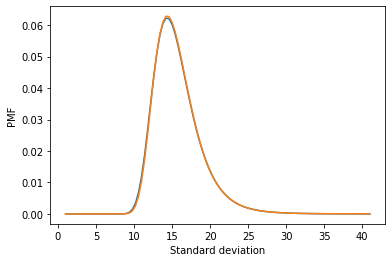

In [22]:
posterior.plot()
posterior2.plot()
plt.xlabel('Standard deviation')
plt.ylabel('PMF');

They are pretty much identical.  However, by eliminating lower standard deviations, the information we have about the minimum and maximum does increase the posterior mean, just slightly.

In [23]:
posterior.mean(), posterior2.mean()

(15.686820411746856, 15.737993355514599)

This section might be useful because it shows how to incorporate the information we have about the minimum score.  But in this case it turns out to provide very little evidence about the standard deviation.

## Using the maximum

We have one more piece of information to work with.  We also know that the high score was 37, which is the maximum score possible.

As an exercise, compute the likelihood of this data under each of the hypothetical standard deviations in `hypos` and use the result to update the posterior.

You should find that it contains almost no additional evidence.

In [24]:
# Solution

pgt37s = norm(22.6, hypos).sf(37)

In [25]:
# Solution

likelihood3 = binom(100, pgt37s).sf(0)

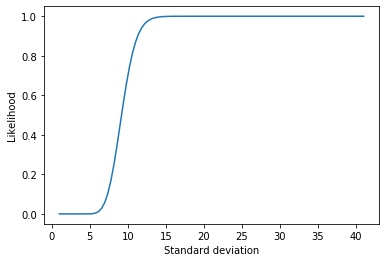

In [26]:
# Solution

plt.plot(hypos, likelihood2)
plt.xlabel('Standard deviation')
plt.ylabel('Likelihood');

In [27]:
# Solution

prior = Pmf(1, hypos)
prior.normalize()
posterior3 = prior * likelihood1 * likelihood2 * likelihood3
posterior3.normalize()

0.015862587041361786

Here's what the posteriors look like:

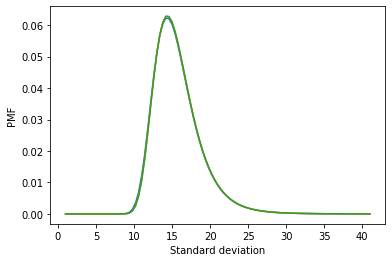

In [28]:
# Solution

posterior.plot()
posterior2.plot()
posterior3.plot()
plt.xlabel('Standard deviation')
plt.ylabel('PMF');

In [29]:
# Solution

posterior.mean(), posterior2.mean(), posterior3.mean()

(15.686820411746856, 15.737993355514599, 15.738014772261733)